*Read the names in the folder*

In [17]:
from glob import glob
dataset_dir = f'./PraxisData'
case_paths = sorted(glob(f"{dataset_dir}/**"))
print(len(case_paths))

3794


Coronal: (512, 512, 24)
Sagittal: (512, 512, 24)
Transversal: (512, 512, 25)


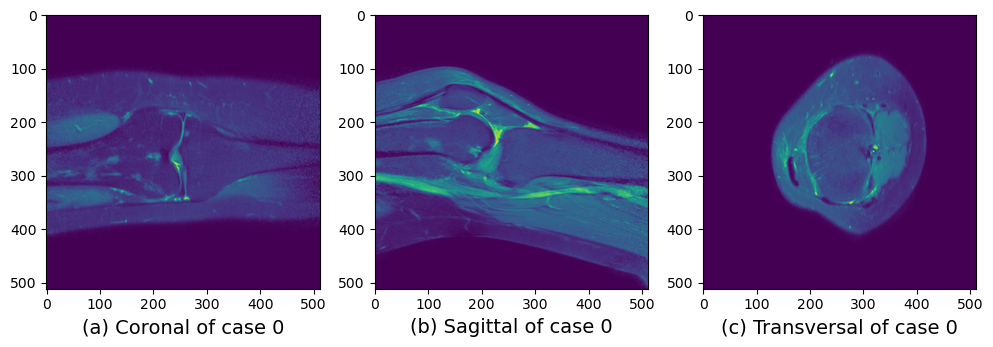

In [3]:
import nibabel as nib
import matplotlib.pyplot as plt

case_num = 0
coronal_path = f"{case_paths[case_num]}/CORONAL_PROTON.nii"
sagittal_path = f"{case_paths[case_num]}/SAGITTAL_PROTON.nii"
transversal_path = f"{case_paths[case_num]}/TRANSVERSAL_PROTON.nii"

coronal = nib.load(coronal_path).get_fdata()
sagittal = nib.load(sagittal_path).get_fdata()
transversal = nib.load(transversal_path).get_fdata()

print(f"Coronal: {coronal.shape}")
print(f"Sagittal: {sagittal.shape}")
print(f"Transversal: {transversal.shape}")

fig,ax = plt.subplots(1,3,figsize=(12,6))
ax[0].imshow(coronal[:,:,10])
ax[0].set_xlabel(f'(a) Coronal of case {case_num}',fontsize = 14)
ax[1].imshow(sagittal[:,:,10])
ax[1].set_xlabel(f'(b) Sagittal of case {case_num}',fontsize = 14)
ax[2].imshow(transversal[:,:,10])
ax[2].set_xlabel(f'(c) Transversal of case {case_num}',fontsize = 14)
plt.show()

*Check how many folders miss planes*

In [4]:
for case_path in case_paths:
    num = len(sorted(glob(f"{case_path}/**.nii")))
    if num != 3:
        print(case_path)

*Calculate the average shape*

In [5]:
import torchio as tio
case_num = float(len(case_paths))

def mean_spacing(plane):
    shape_1 = 0.0
    shape_2 = 0.0
    shape_3 = 0.0
    for case_path in case_paths:
        if plane == "coronal":
            path = f"{case_path}/CORONAL_PROTON.nii"
        elif plane == "sagittal":
            path = f"{case_path}/SAGITTAL_PROTON.nii"
        elif plane == "transversal":
            path = f"{case_path}/TRANSVERSAL_PROTON.nii"
        test = tio.ScalarImage(path)
        shape_1 += test.spacing[0]
        shape_2 += test.spacing[1]
        shape_3 += test.spacing[2]
    mean_spacing = (shape_1/case_num, shape_2/case_num, shape_3/case_num)
    print(f"{plane}_spacing: {mean_spacing}")
    return mean_spacing

coronal_spacing = mean_spacing("coronal")
sagittal_spacing = mean_spacing("sagittal")
transversal_spacing = mean_spacing("transversal")

coronal_spacing: (0.3577202787494182, 0.3577202787494182, 3.7273127132801864)
sagittal_spacing: (0.3571460647572325, 0.3571460647572325, 3.6317453559568573)
transversal_spacing: (0.3432912426476863, 0.3432912426476863, 3.989583602439245)


*Calculate the mean shape after changing the spacing  (This step will take a long time so I didn't finish it here)*

In [ ]:
def mean_shape(plane):
    shape_1 = 0.0
    shape_2 = 0.0
    shape_3 = 0.0
    for case_path in case_paths:
        if plane == "coronal":
            path = f"{case_path}/CORONAL_PROTON.nii"
            space = coronal_spacing
        elif plane == "sagittal":
            path = f"{case_path}/SAGITTAL_PROTON.nii"
            space = sagittal_spacing
        elif plane == "transversal":
            path = f"{case_path}/TRANSVERSAL_PROTON.nii"
            space = transversal_spacing
        test = tio.ScalarImage(path)
        preprocess = tio.Compose([tio.Resample(space)])
        preprocess_test = preprocess(test)
        shape_1 += preprocess_test.shape[1]
        shape_2 += preprocess_test.shape[2]
        shape_3 += preprocess_test.shape[3]
    
    mean_shape = (shape_1/case_num, shape_2/case_num, shape_3/case_num)
    print(f"{plane}_shape: {mean_shape}")
    return mean_shape

coronal_shape = mean_shape("coronal")
sagittal_shape = mean_shape("sagittal")
transversal_shape = mean_shape("transversal")

In [16]:
import pandas as pd
# Read the average spacing from csv
spacing_path = "./src_preprocess/csv/mean_spacing.csv"
df = pd.read_csv(spacing_path, header=None)
lst = df.values.tolist()
new_lst = [tuple(x) for x in lst]

coronal_spacing = tuple([float(x) for x in new_lst[1]])
sagittal_spacing = tuple([float(x) for x in new_lst[2]])
transversal_spacing = tuple([float(x) for x in new_lst[3]])

# After the calculation of previous step
coronal_shape = (512,512,25)
sagittal_shape = (512,512,25)
transversal_shape = (512,512,27)

# Resample and crop

*Save the preprocessed dataset*

In [ ]:
import torchio as tio
import os
def resample_crop(plane,case_paths,space,shape):
    for case_path in case_paths:
        path = f"{case_path}/{plane.upper()}_PROTON.nii"

        test = tio.ScalarImage(path)
        preprocess = tio.Compose([tio.Resample(space),tio.CropOrPad(target_shape=shape)])
        preprocess_test = preprocess(test)

        dir_path, file_name = os.path.split(path)
        folder_name = os.path.basename(dir_path)
        directory = f'./Preprocessed_dataset/{folder_name}'
        if not os.path.exists(directory):
            os.makedirs(directory)
        
        preprocess_test.save(f'{directory}/{file_name}')

resample_crop("coronal",case_paths,coronal_spacing,coronal_shape)
resample_crop("sagittal",case_paths,sagittal_spacing,sagittal_shape)
resample_crop("transversal",case_paths,transversal_spacing,transversal_shape)

*Difference between the previous image and current image*

Coronal_current: (512, 512, 25)
Coronal_previous: (512, 512, 24)


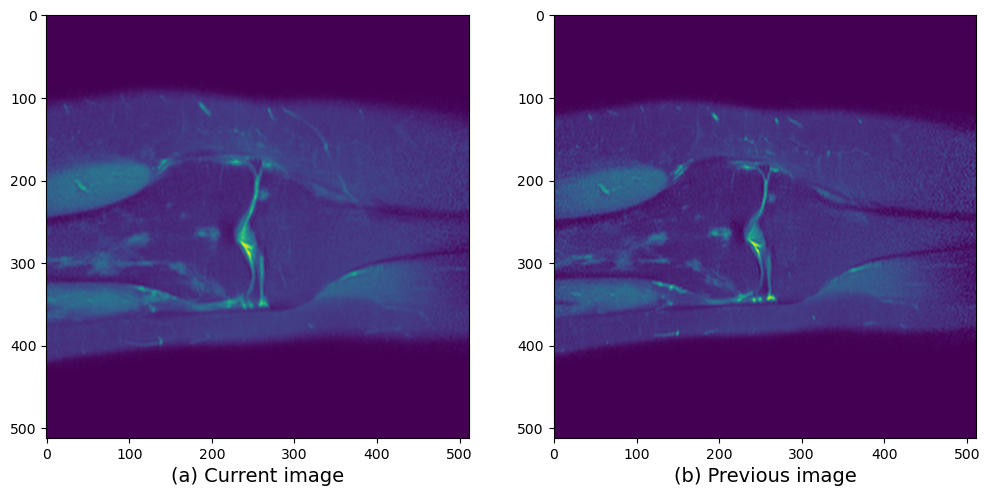

In [19]:
import nibabel as nib
import matplotlib.pyplot as plt
from glob import glob

case_idx = 0
plane = "coronal"
slice = 10

# New preprocessed dataset
dataset_dir_current = f'./Preprocessed_dataset'
case_paths_current = sorted(glob(f"{dataset_dir_current}/**"))

coronal_path_current = f"{case_paths_current[case_idx]}/{plane.upper()}_PROTON.nii"
coronal_path_previous = f"{case_paths[case_idx]}/{plane.upper()}_PROTON.nii"

coronal_current = nib.load(coronal_path_current).get_fdata()
coronal_previous = nib.load(coronal_path_previous).get_fdata()

print(f"Coronal_current: {coronal_current.shape}")
print(f"Coronal_previous: {coronal_previous.shape}")

fig,ax = plt.subplots(1,2,figsize=(12,6))
ax[0].imshow(coronal_current[:,:,slice])
ax[0].set_xlabel(f'(a) Current image',fontsize = 14)
ax[1].imshow(coronal_previous[:,:,slice])
ax[1].set_xlabel(f'(b) Previous image',fontsize = 14)
plt.show()

In [5]:
# check if any files are missing
for case_path in case_paths_current:
    num = len(sorted(glob(f"{case_path}/**.nii")))
    if num != 3:
        print(case_path)

# Histogram Standardization

In [7]:
# Exract the histograms from the dataset
import torch
from glob import glob
import numpy as np
from pathlib import Path
from torchio.transforms import HistogramStandardization

# New preprocessed dataset
dataset_dir_current = f'./Preprocessed_dataset'
case_paths_current = sorted(glob(f"{dataset_dir_current}/**"))

coronal_paths = []
sagittal_paths = []
transversal_paths = []
for case_path in case_paths_current:
    coronal_paths.append(f"{case_path}/CORONAL_PROTON.nii")
    sagittal_paths.append(f"{case_path}/SAGITTAL_PROTON.nii")
    transversal_paths.append(f"{case_path}/TRANSVERSAL_PROTON.nii")

coronal_landmarks_path = Path('./src_preprocess/npy_backup/coronal_landmarks.npy')
sagittal_landmarks_path = Path('./src_preprocess/npy_backup/sagittal_landmarks.npy')
transversal_landmarks_path = Path('./src_preprocess/npy_backup/transversal_landmarks.npy')

coronal_landmarks = (
    coronal_landmarks_path
    if coronal_landmarks_path.is_file()
    else HistogramStandardization.train(coronal_paths)    
)
np.save(coronal_landmarks_path, coronal_landmarks)

sagittal_landmarks = (
    sagittal_landmarks_path
    if sagittal_landmarks_path.is_file()
    else HistogramStandardization.train(sagittal_paths)    
)
np.save(sagittal_landmarks_path, sagittal_landmarks)

transversal_landmarks = (
    transversal_landmarks_path
    if transversal_landmarks_path.is_file()
    else HistogramStandardization.train(transversal_paths)    
)
np.save(transversal_landmarks_path, transversal_landmarks)

*Save the Histogram Standardization in the csv file*

In [12]:
import csv
import os
import torchio as tio

def create_spacing_csv(his_stand_path):
    with open(f'{his_stand_path}', mode='w') as his_stand_csv:
        fields = ['Histogram Standardization']
        writer = csv.DictWriter(his_stand_csv, fieldnames=fields)
        writer.writeheader()
    
    return his_stand_path

def save_spacing(data,his_stand_path):
    with open(f'{his_stand_path}', mode='a') as his_stand_csv:
        writer = csv.writer(his_stand_csv)
        writer.writerow(data)

his_stand_path = "./src_preprocess/csv/his_stand.csv"
if not os.path.exists(his_stand_path):
    his_stand_path = create_spacing_csv(his_stand_path)
    planes = ['coronal','sagittal','transversal']
    for plane in planes:
        data = np.load(f'./src_preprocess/npy_files/{plane}_landmarks.npy')
        save_spacing(data, his_stand_path)

# Read lines in csv file
file = open(his_stand_path,"r")
data = list(csv.reader(file, delimiter=","))
file.close()

coronal_his = np.array([float(x) for x in data[1]])
sagittal_his = np.array([float(x) for x in data[2]])
transversal_his = np.array([float(x) for x in data[3]])

landmarks_dict = {
    'coronal': coronal_his,
    'sagittal': sagittal_his,
    'transversal': transversal_his,
    }

transform = tio.HistogramStandardization(landmarks_dict)#, masking_method=tio.ZNormalization.mean) #, include=["coronal", "sagittal", "transversal"])

*Read the .nii files as the subject*

In [13]:
data_coronal = tio.ScalarImage(coronal_paths)
data_sagittal = tio.ScalarImage(sagittal_paths)
data_transversal = tio.ScalarImage(transversal_paths)

subject = tio.Subject(
    coronal = data_coronal,
    sagittal = data_sagittal,
    transversal = data_transversal
)
print(subject)

Subject(Keys: ('coronal', 'sagittal', 'transversal'); images: 3)


*Transform all the cases and save them in the new folder*

In [48]:
output_dataset = './Preprocessed_dataset_2'

i = 0 # for loop couldn't be used here
while i < len(case_paths_current):
    case_path = case_paths_current[i]
    coronal_paths = f"{case_path}/CORONAL_PROTON.nii"
    sagittal_paths = f"{case_path}/SAGITTAL_PROTON.nii"
    transversal_paths = f"{case_path}/TRANSVERSAL_PROTON.nii"
    data_coronal = tio.ScalarImage(coronal_paths)
    data_sagittal = tio.ScalarImage(sagittal_paths)
    data_transversal = tio.ScalarImage(transversal_paths)
    
    subject = tio.Subject(
        coronal = data_coronal,
        sagittal = data_sagittal,
        transversal = data_transversal
    )

    output = transform(subject)

    planes = ['coronal','sagittal','transversal']
    for plane in planes:
        path = f"{case_path}/{plane.upper()}_PROTON.nii"

        dir_path, file_name = os.path.split(path)
        folder_name = os.path.basename(dir_path)
        directory = f'{output_dataset}/{folder_name}'
        if not os.path.exists(directory):
            os.makedirs(directory)
        
        output[plane].save(f'{directory}/{file_name}')
    print(f"Case number: {i}")
    i += 1

*Previous code: using for loop to save the files but doesn't work*

In [ ]:
output_dataset = './Preprocessed_dataset_2'

def read_data(plane,case_path):
    path = f"{case_path}/{plane.upper()}_PROTON.nii"
    data = tio.ScalarImage(path)
    return data

for i,cath_path in enumerate(case_paths_current):
    subject = tio.Subject(
        coronal = read_data("coronal",cath_path),
        sagittal = read_data("sagittal",cath_path),
        transversal = read_data("transversal",cath_path)
    )

    output = transform(subject)

    planes = ['coronal','sagittal','transversal']
    for plane in planes:
        path = f"{case_path}/{plane.upper()}_PROTON.nii"

        dir_path, file_name = os.path.split(path)
        folder_name = os.path.basename(dir_path)
        directory = f'{output_dataset}/{folder_name}'
        if not os.path.exists(directory):
            os.makedirs(directory)
        
        output[plane].save(f'{directory}/{file_name}')

    print(f"Current case: {i}")

# With and Without the mask

Coronal_current: (512, 512, 25)
Coronal_previous: (512, 512, 25)


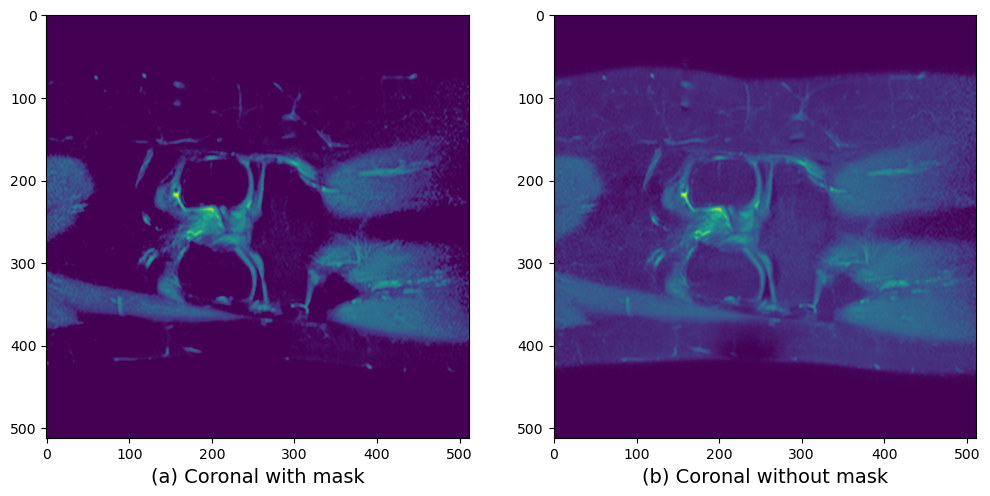

In [1]:
# Add it or not: masking_method=tio.ZNormalization.mean
import nibabel as nib
import matplotlib.pyplot as plt

coronal_path_current = "./Examples_for_output/with_mask.nii"
coronal_path_previous = "./Examples_for_output/without_mask.nii"

coronal_current = nib.load(coronal_path_current).get_fdata()
coronal_previous = nib.load(coronal_path_previous).get_fdata()

print(f"Coronal_current: {coronal_current.shape}")
print(f"Coronal_previous: {coronal_previous.shape}")

fig,ax = plt.subplots(1,2,figsize=(12,6))
ax[0].imshow(coronal_current[:,:,15])
ax[0].set_xlabel(f'(a) Coronal with mask',fontsize = 14)
ax[1].imshow(coronal_previous[:,:,15])
ax[1].set_xlabel(f'(b) Coronal without mask',fontsize = 14)
plt.show()

# Comparison: Original, Resized, Histogram Standardization

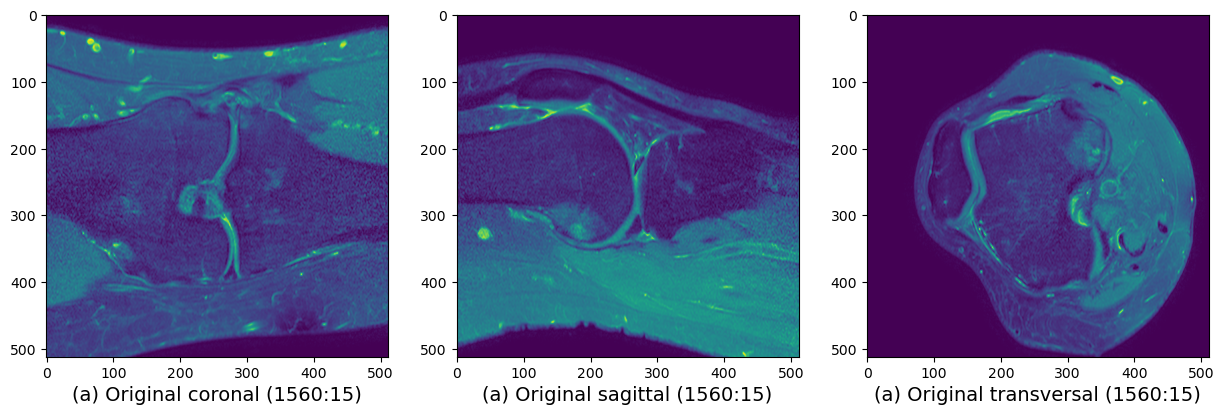

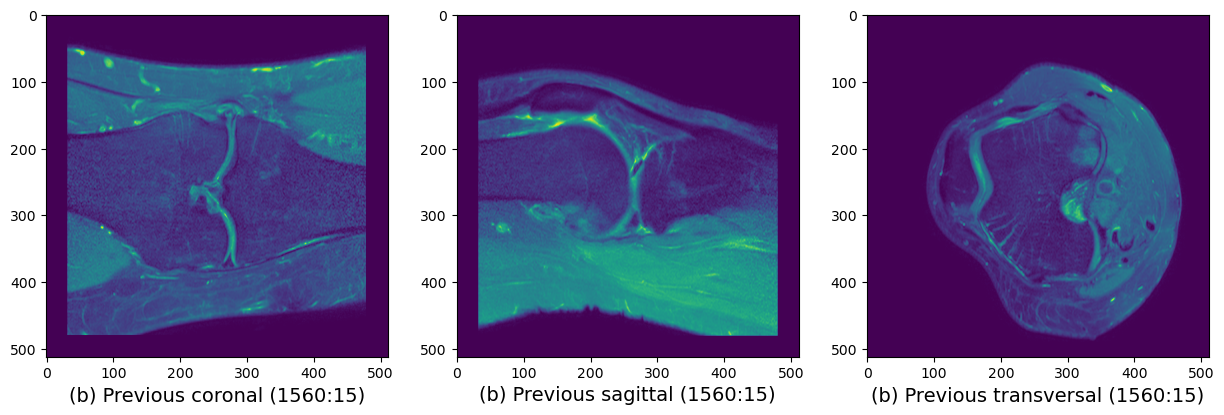

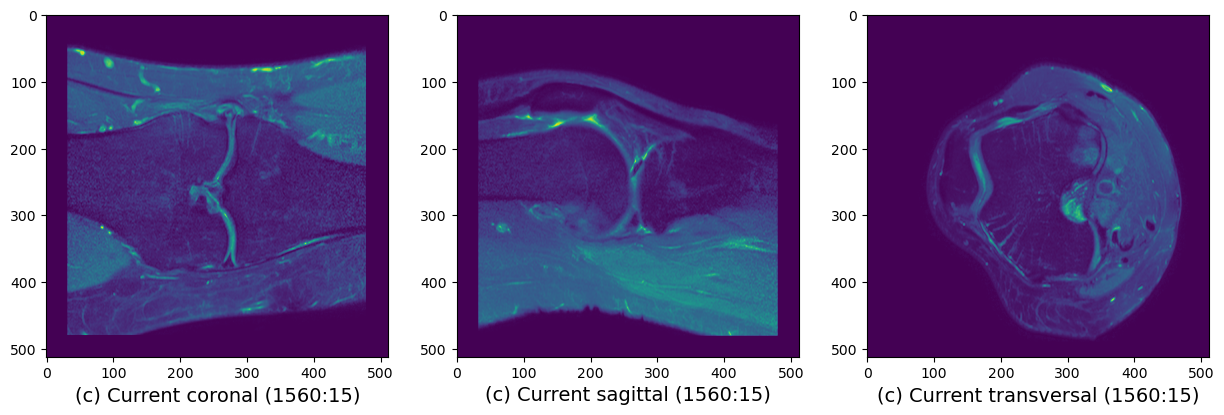

In [14]:
from glob import glob
import nibabel as nib
import matplotlib.pyplot as plt
import os

case_num = 1560 #1251
slice_num = 15

def current_path(path,dataset_dir):
    dir_path, file_name = os.path.split(path)
    folder_name = os.path.basename(dir_path)
    dictionary = f'{dataset_dir}/{folder_name}/{file_name}'
    return dictionary

# Read the files in the original dataset
dataset_dir = f'./PraxisData'
case_paths = sorted(glob(f"{dataset_dir}/**"))

coronal_paths = []
sagittal_paths = []
transversal_paths = []
for case_path in case_paths:
    coronal_paths.append(f"{case_path}/CORONAL_PROTON.nii")
    sagittal_paths.append(f"{case_path}/SAGITTAL_PROTON.nii")
    transversal_paths.append(f"{case_path}/TRANSVERSAL_PROTON.nii")

coronal_original = nib.load(coronal_paths[case_num]).get_fdata()
sagittal_original = nib.load(sagittal_paths[case_num]).get_fdata()
transversal_original = nib.load(transversal_paths[case_num]).get_fdata()
# print(coronal_paths[case_num])

# Read the corresponding file in the dataset_1
dataset_dir_1 = f'./Preprocessed_dataset/'

coronal_previous = nib.load(current_path(coronal_paths[case_num],dataset_dir_1)).get_fdata()
sagittal_previous = nib.load(current_path(sagittal_paths[case_num],dataset_dir_1)).get_fdata()
transversal_previous = nib.load(current_path(transversal_paths[case_num],dataset_dir_1)).get_fdata()

# Read the corresponding file in the dataset_2
dataset_dir_2 = f'./Preprocessed_dataset_2/'

coronal_current = nib.load(current_path(coronal_paths[case_num],dataset_dir_2)).get_fdata()
sagittal_current = nib.load(current_path(sagittal_paths[case_num],dataset_dir_2)).get_fdata()
transversal_current = nib.load(current_path(transversal_paths[case_num],dataset_dir_2)).get_fdata()
# print(current_path(coronal_paths[case_num],dataset_dir_2))

fig,ax = plt.subplots(1,3,figsize=(15,6))
ax[0].imshow(coronal_original[:,:,slice_num])
ax[0].set_xlabel(f'(a) Original coronal ({case_num}:{slice_num})',fontsize = 14)
ax[1].imshow(sagittal_original[:,:,slice_num])
ax[1].set_xlabel(f'(a) Original sagittal ({case_num}:{slice_num})',fontsize = 14)
ax[2].imshow(transversal_original[:,:,slice_num])
ax[2].set_xlabel(f'(a) Original transversal ({case_num}:{slice_num})',fontsize = 14)
plt.show()

fig,ax = plt.subplots(1,3,figsize=(15,6))
ax[0].imshow(coronal_previous[:,:,slice_num])
ax[0].set_xlabel(f'(b) Previous coronal ({case_num}:{slice_num})',fontsize = 14)
ax[1].imshow(sagittal_previous[:,:,slice_num])
ax[1].set_xlabel(f'(b) Previous sagittal ({case_num}:{slice_num})',fontsize = 14)
ax[2].imshow(transversal_previous[:,:,slice_num])
ax[2].set_xlabel(f'(b) Previous transversal ({case_num}:{slice_num})',fontsize = 14)
plt.show()

fig,ax = plt.subplots(1,3,figsize=(15,6))
ax[0].imshow(coronal_current[:,:,slice_num])
ax[0].set_xlabel(f'(c) Current coronal ({case_num}:{slice_num})',fontsize = 14)
ax[1].imshow(sagittal_current[:,:,slice_num])
ax[1].set_xlabel(f'(c) Current sagittal ({case_num}:{slice_num})',fontsize = 14)
ax[2].imshow(transversal_current[:,:,slice_num])
ax[2].set_xlabel(f'(c) Current transversal ({case_num}:{slice_num})',fontsize = 14)
plt.show()